* By Ahmed Elshayeb (aelshayeb@jacobs-alumni.de)

## FilterMatrix class functions

This description is partially based on the __scikit-learn User Guide on Covariance estimation__ [available here](https://scikit-learn.org/stable/modules/covariance.html#robust-covariance).

## Introduction

FilterMatrix class includes the implementations of functions for different ways to adjust Covariance matrices.

The following algorithms currently implemented: 

- De-noising Covariance/Correlation Matrix
  - Spectral Clustering De-noising Method
  - Hierarchical Clustering De-noising Method
- Transforming covariance matrix to correlation matrix and back

This Notebook will describe the above algorithms as well as provide use cases and analysis of results.

## De-noising Covariance/Correlation Matrix

### Spectral Clustering De-noising Method

The main idea behind spectral clustering is to remove the noise-related eigenvalues from an empirical correlation matrix, the method in which this is achieved is by setting the eigenvalues which are below the theoretical value to their average value, they are set to zero in an attempt to remove the effects of those eigenvalues that are consistent with the null hypothesis of uncorrelated random variables.

Let us consider $n$ independent random variables with finite variance and $T$ records each. Random matrix
theory allows to prove that in the $\lim\limits_{n \to \infty} T$, with a fixed ratio $Q = T/n \geq 1$, the
eigenvalues of the sample correlation matrix cannot be larger than

$$ \lambda_{max} = \sigma^2(1 + \frac{1}{Q} + 2\sqrt{\frac{1}{Q}})$$

where $\sigma^2 = 1$ for correlation matrices, once achieved we set any eignevalues above this threshold to $0$.
For example, we have a set of 5 eigenvalues sorted in the descending order ( $\lambda_1$ ... $\lambda_5$ ),
3 of which are below the maximum theoretical value, then we set

$$ \lambda_3^{NEW} = \lambda_4^{NEW} = \lambda_5^{NEW} = 0$$

- Eigenvalues above the maximum theoretical value are left intact.

$$\lambda_1^{NEW} = \lambda_1^{OLD}$$

$$\lambda_2^{NEW} = \lambda_2^{OLD}$$

- The new set of eigenvalues with the set of eigenvectors is used to obtain the new de-noised correlation matrix. $\tilde{C}$ is the de-noised correlation matrix, $W$ is the eigenvectors matrix, and $\Lambda$ is the diagonal matrix with new eigenvalues.

$$\tilde{C} = W \Lambda W$$

- To rescale $\tilde{C}$ so that the main diagonal consists of 1s the following transformation is made. This is how the final $C_{denoised}$ is obtained.

$$C_{denoised} = \tilde{C} [(diag[\tilde{C}])^\frac{1}{2}(diag[\tilde{C}])^{\frac{1}{2}'}]^{-1}$$

- The new correlation matrix is then transformed back to the new de-noised covariance matrix.

The process of de-noising the covariance matrix is described in a paper by _Potter M._, _J.P. Bouchaud_, _L. Laloux_ __“Financial applications of random matrix theory: Old laces and new pieces.”__  [available here](https://arxiv.org/abs/physics/0507111).

#### Example

In [1]:
# Imports
import pandas as pd
import numpy as np

from datascience.filter.filter import Filtermatrix

In [2]:
# Getting the data
stock_prices = pd.read_csv('../datascience/dataset/stock_prices.csv', parse_dates=True, index_col='Date', dayfirst=True)
stock_prices = stock_prices.dropna(axis=1)

# Leaving only 5 stocks in the dataset, so the differences between the 
# calculated covariance matrices would be easy to observe.
stock_prices = stock_prices.iloc[:, :5]
stock_prices.head()

,EEM,EWG,TIP,EWJ,EFA
Date,,,,,
2008-01-02,49.273335,35.389999,106.639999,52.919998,78.220001
2008-01-03,49.716667,35.290001,107.000000,53.119999,78.349998
2008-01-04,48.223331,34.599998,106.970001,51.759998,76.570000
2008-01-07,48.576668,34.630001,106.949997,51.439999,76.650002
2008-01-08,48.200001,34.389999,107.029999,51.320000,76.220001


In [3]:
# Now we can calculate the returns from the prices
stock_returns = stock_prices.pct_change()
stock_returns.dropna(inplace=True, how='all')

# Relation of number of observations T to the number of variables N (T/N)
tn_relation = stock_prices.shape[0] / stock_prices.shape[1]

# Get the positive definate covariance and correlation matricies 
cov_matrix = stock_returns.cov() 
corr_matrix = stock_returns.corr()

In [4]:
# Initiate class Filtermatrix
filt = Filtermatrix()

# Filter the covariance matrix using Spectral Clustering De-noising method
cov_matrix_spectral = filt.denoise_covariance(cov_matrix, tn_relation)

# Transforming De-noised Covariance from np.array to pd.DataFrame
cov_matrix_spectral = pd.DataFrame(cov_matrix_spectral, index=cov_matrix.index, columns=cov_matrix.columns)

# Outputting the result
print('The Spectral Clustering De-noised Сovariance matrix is:')
cov_matrix_spectral

The Spectral Clustering De-noised Сovariance matrix is:


,EEM,EWG,TIP,EWJ,EFA
EEM,0.000466,0.000416,-0.000095,0.000329,0.000360
EWG,0.000416,0.000372,-0.000085,0.000294,0.000322
TIP,-0.000095,-0.000085,0.000019,-0.000067,-0.000073
EWJ,0.000329,0.000294,-0.000067,0.000232,0.000254
EFA,0.000360,0.000322,-0.000073,0.000254,0.000278


### Hierarchical Clustering De-noising Method

Hierarchical Clustering, unlike K-means Clustering, does not create multiple clusters of identical size, nor does it
require a pre-defined number of clusters. Of the two different types of hierarchical clustering - Agglomerative and
Divisive - Agglomerative, or bottom-up clustering is used here.

Agglomerative Clustering assigns each observation to its own individual cluster before iteratively joining the two
most similar clusters. This process repeats until only a singular cluster remains.

Given a positive empirical correlation matrix, $C$ generated using $n$ features, the procedure given below
returns as an output a rooted tree and a filtered correlation matrix $C^<$ of elements $c^<_{ij}$.

First, set $C = C^<$. 

Then, beginning with the most highly correlated features (clusters) $h$ and $k \in C$ and the correlation
between them, $c_{hk}$, one sets the elements $c^<_{ij} = c^<_{ji} = c_{hk}$.

The matrix $C^<$ is then redefined such that:

$$\begin{cases} c^<_{qj} = f(c^<_{hj}, c^<_{kj}) & where \ j \notin h \ and \ j \notin k \\ c^<_{ij} = c^<_{ij} & otherwise \end{cases}$$

where $f(c^<_{hj}, c^<_{kj})$ is any distance metric. In effect, merging the clusters $h$ and $k$.
These steps are then completed for the next two most similar clusters, and are repeated for a total
of $n-1$ iterations; until only a single cluster remains.

There are a few methods to use with Hierarchical Clustering for calculating the distance metric, here are 3 of them:

- **Single** $d(u,v) = min(dist(u[i], v[j]))$ for all points $i$ in cluster $u$ and $j$ in cluster $v$. This is also known as the Nearest Point Algorithm.

- **Complete** $d(u,v) = max(dist(u[i], v[j]))$ for all points $i$ in cluster $u$ and $j$ in cluster $v$. This is also known by the Farthest Point Algorithm or Voor Hees Algorithm

- **Average** $d(u,v) = \displaystyle\sum_{ij} \frac{d(u[i], v[j])}{|u| * |v|}$ for all points $i$ in cluster $|u|$ and $|j|$ in cluster $u$ and $v$, respectively. This is also called the UPGMA algorithm.

The process of de-noising the covariance/correlation matrix using Hierarchichal Clustering is described in a paper by _Michele Tumminello_, _Fabrizio Lillo_, and _Rosario N. Mantegna_  __“Correlation, hierarchies, and networks in financial markets”__  [available here](https://arxiv.org/pdf/0809.4615.pdf).

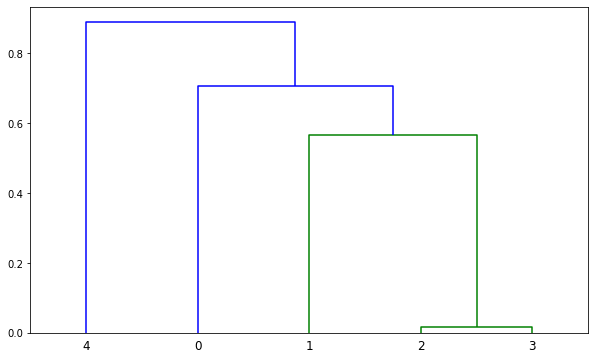

In [5]:
# The Hierarchical Clustering requires a positive correlation matrix
# Compute the square of the correlation matrix to get rid of the negative values
corr_positive = np.array(corr_matrix ** 2)

# Filter the covariance matrix using the Hierarchical Clustering De-noising method
corr_matrix_hierarchical = filt.filter_corr_hierarchical(corr_positive, method='complete', draw_plot=True)

_Figure above shows the Dendogram of the hierarchichal clustered matrix where X-axis includes the column ID, and_

_the Y-axis shows the alpha(filtered) value of the correlations for each pair_

## Conclusion

This notebook describes the functions implemented in the FilterMatrix class, related to different ways of adjusting the Covariance matrix. Also, it shows how the corresponding functions from the this library can be used and how the outputs can be analyzed.

Key takeaways from the notebook:
- The Spectral Clustering De-noising Method calculates the eigenvalues of the correlation matrix and eliminates the ones that are lower than the theoretically estimated ones, as they are caused by noise.
- The Hierarchical Clustering De-noising Method is used to filter empirical correlation matrices using Agglomerative Clustering.